In [26]:
#Librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Arbol de decision
from sklearn.tree import DecisionTreeClassifier#-


#Visualizacion del arbol
from sklearn.tree import plot_tree#x

#Para el bosque aleatorio.
from sklearn.ensemble import RandomForestClassifier

#Para el reporte
from sklearn.metrics import classification_report, accuracy_score,make_scorer#-
from sklearn.model_selection import ParameterGrid, GridSearchCV

In [2]:
#Importacion del dataset
dataset = pd.read_csv("framinghamClean.csv")
dataset.drop(["Unnamed: 0"], axis=1, inplace=True)
dataset.head()
#dataset.shape

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Preparacion del modelo.

In [3]:
#Eleccion de variables
columnas = dataset.columns.values.tolist()
predictors = columnas[:15]
target = columnas[-1]

In [4]:
#Se hara una columna is_train
dataset["is_train"] = (np.random.uniform(0,1,len(dataset))<=0.75).astype(int)

(array([1011.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3229.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

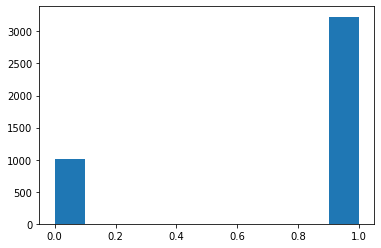

In [5]:
#Distribucion de los conjuntos, train, test.
plt.hist(dataset.is_train)

In [6]:
train, test = dataset[dataset["is_train"]==True], dataset[dataset["is_train"]==False]
len(train),len(test)

(3229, 1011)

In [7]:
X = dataset[predictors]
Y = dataset[target]
x_train = train[predictors]
y_train = train[target]
x_test =  test[predictors]
y_test =  test[target]

In [27]:
tree = DecisionTreeClassifier(criterion="entropy",max_depth=4 , min_samples_split=20, random_state=99)#Numero minimo para hacer division por defult es 2 pero genera overfitign, random_state=99 puede ser cualquiera
tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=20,
                       random_state=99)

In [9]:
preds = tree.predict(test[predictors])
#list(preds)
len(preds)

1011

In [10]:
pd.crosstab(y_test,preds,rownames=["Actual"],colnames=["Predictions"])

Predictions,0,1
Actual,,
0,844,14
1,142,11


## Visualizacion del arbol de decision

In [11]:
'''plt.figure(figsize=(6,6),dpi=1000)
plot_tree(tree,feature_names=columnas,filled=True)
plt.show()'''

'plt.figure(figsize=(6,6),dpi=1000)\nplot_tree(tree,feature_names=columnas,filled=True)\nplt.show()'

In [12]:
from sklearn.tree import export_graphviz

In [13]:
with open("/Users/antonioreyesguerrero/Desktop/DataS/ProyectosDataScience/Supervisados/framinghan/framinghan_three.dot", "w") as dotfile:
    export_graphviz(tree,out_file=dotfile, feature_names=predictors)
    dotfile.close()

In [14]:
import os
from graphviz import Source

In [15]:
file = open("/Users/antonioreyesguerrero/Desktop/DataS/ProyectosDataScience/Supervisados/framinghan/framinghan_three.dot","r")
text = file.read()

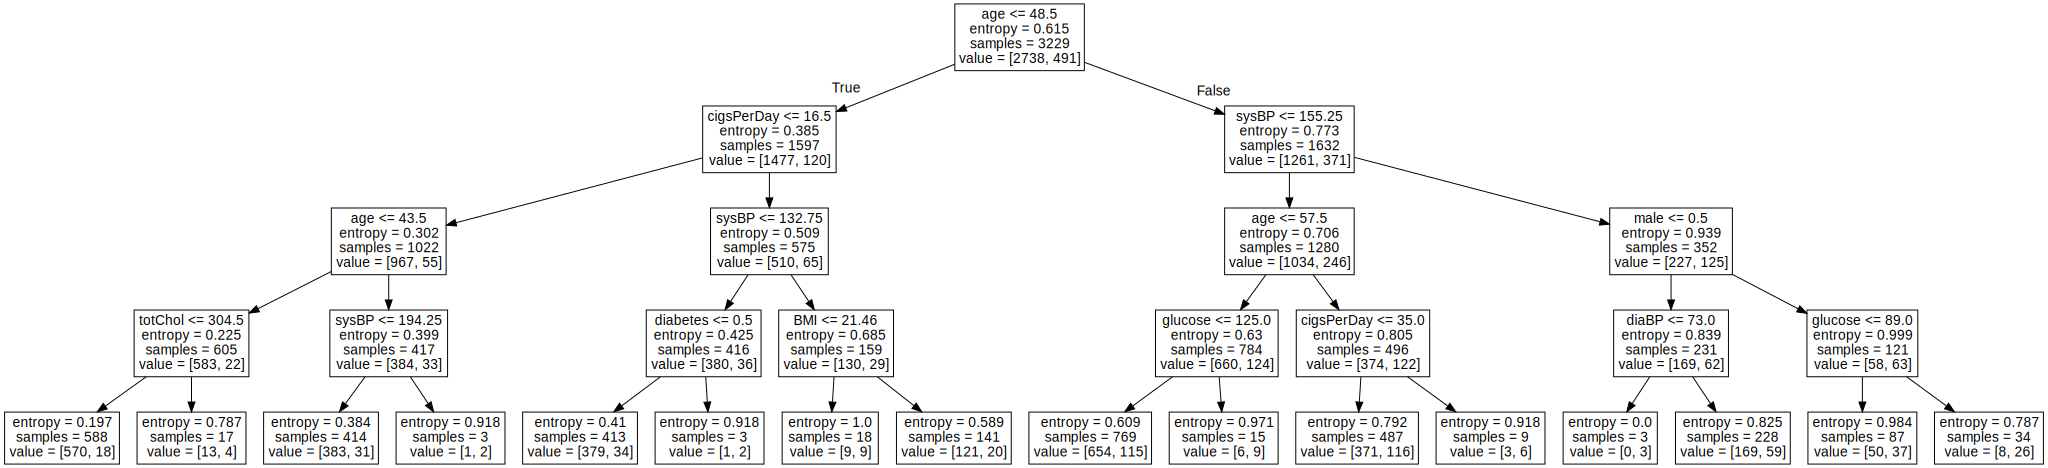

In [16]:
Source(text)

In [17]:
from sklearn.model_selection import KFold

In [18]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)

In [19]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics

In [20]:
score = np.mean(cross_val_score(tree,X,Y,scoring="accuracy",cv=cv,n_jobs=1))

In [21]:
score

0.8455188679245284

In [22]:
print(classification_report(y_test,tree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       858
           1       0.44      0.07      0.12       153

    accuracy                           0.85      1011
   macro avg       0.65      0.53      0.52      1011
weighted avg       0.79      0.85      0.80      1011



# Optimizacion
Hasta este punto el arbol en una profundidad de 4 mantiene una precision de un .85 por ciento, sin embargo en el aspecto de predecir si el paciente puede desarrollar una enfermedad tiene un pobre desempeño.
Se intentaras varias cosas extraidas de diversos articulos que he leido.
* Maxima profundidad.
* Numero de samples.
* Post-pruning: se usara el cost-complexity parameter.

In [24]:
#Una forma de hacerlo
for i in range(1,11):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=i, min_samples_split=30, random_state=99)
    tree.fit(X,Y)
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    score = np.mean(cross_val_score(tree,X,Y,scoring="accuracy",cv=cv,n_jobs=1))
    print("Score para i",i ,"es de:  ",score)
    #print(" ",tree.feature_importances_)

Score para i 1 es de:   0.8481132075471697
Score para i 2 es de:   0.8481132075471697
Score para i 3 es de:   0.8450471698113207
Score para i 4 es de:   0.8462264150943397
Score para i 5 es de:   0.8429245283018867
Score para i 6 es de:   0.8410377358490566
Score para i 7 es de:   0.8358490566037735
Score para i 8 es de:   0.8334905660377359
Score para i 9 es de:   0.8294811320754718
Score para i 10 es de:   0.8240566037735849


In [28]:
max_depth = tree.get_depth()
max_depth

4

In [29]:
max_depth_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=99),
    scoring=make_scorer(accuracy_score),
    param_grid = ParameterGrid(
        {"max_depth": [[max_depth] for max_depth in range(1,max_depth +1)]}
        
    ),
)

In [30]:
max_depth_grid_search.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=99),
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x1247736d0>,
             scoring=make_scorer(accuracy_score))

In [32]:
best_max_depth_tree = max_depth_grid_search.best_estimator_

In [33]:
best_max_depth = best_max_depth_tree.get_depth()

In [34]:
best_max_depth

1

In [35]:
print(classification_report(y_test,tree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       858
           1       0.44      0.07      0.12       153

    accuracy                           0.85      1011
   macro avg       0.65      0.53      0.52      1011
weighted avg       0.79      0.85      0.80      1011



## Post-poda

In [36]:
ccp_alphas = tree.cost_complexity_pruning_path(x_train,y_train)["ccp_alphas"]

In [37]:
ccp_alphas

array([0.        , 0.00139506, 0.00147371, 0.00161453, 0.0017872 ,
       0.00203208, 0.00230955, 0.00263088, 0.00338567, 0.003972  ,
       0.00485421, 0.0086664 , 0.03379116])

In [38]:
ccp_alpha_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=99),
    scoring=make_scorer(accuracy_score),
    param_grid=ParameterGrid({"ccp_alpha": [[alpha] for alpha in ccp_alphas]}),
)

In [39]:
ccp_alpha_grid_search.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=99),
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x1254ce790>,
             scoring=make_scorer(accuracy_score))

In [40]:
ccp_alpha_grid_search.best_params_

{'ccp_alpha': 0.004854207543748587}

In [42]:
best_ccp_alpha_tree = ccp_alpha_grid_search.best_estimator_
best_ccp_alpha_tree

DecisionTreeClassifier(ccp_alpha=0.004854207543748587, random_state=99)

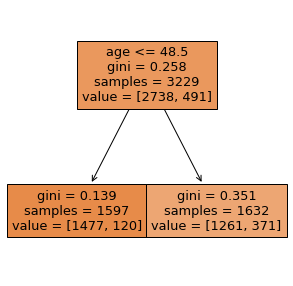

In [43]:
plt.figure(figsize=(5,5))
plot_tree(
    best_ccp_alpha_tree,
    feature_names=columnas,
    filled=True)
plt.show()

In [44]:
print(classification_report(y_test,best_ccp_alpha_tree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       858
           1       0.00      0.00      0.00       153

    accuracy                           0.85      1011
   macro avg       0.42      0.50      0.46      1011
weighted avg       0.72      0.85      0.78      1011



/Users/antonioreyesguerrero/Desktop/PythonCurso/Datos/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonioreyesguerrero/Desktop/PythonCurso/Datos/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antonioreyesguerrero/Desktop/PythonCurso/Datos/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh